In [4]:

import pandas as pd
import requests
from pandas import json_normalize
import time
from datetime import datetime, timedelta
import numpy as np
from pandas.plotting import lag_plot

import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
# Draw chart
import matplotlib.pyplot as plt

#LSTM
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint

#
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # đo phần trăm sai số tuyệt đối trung bình

#ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [5]:
import pandas as pd


def load_aqi_data_from_file(file_path, start_date, end_date, location):
    # Đọc CSV (có thể dùng hàm robust trước đó nếu bạn muốn)
    df = pd.read_csv(file_path, low_memory=False, on_bad_lines='skip')

    # Ép thời gian: tz-aware UTC (bỏ infer_datetime_format)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)

    # start/end cũng tz-aware UTC
    start = pd.to_datetime(start_date, utc=True)
    end   = pd.to_datetime(end_date, utc=True)

    # So khớp địa điểm không phân biệt hoa/thường & khoảng trắng
    def norm(s): return s.strip().casefold() if isinstance(s, str) else s
    df['location_name_norm'] = df['location_name'].astype(str).map(norm)
    location_norm = norm(location)

    mask = (
        df['timestamp'].between(start, end, inclusive='both') &
        (df['location_name_norm'] == location_norm)
    )
    df_filtered = df.loc[mask].copy()

    cols = ['timestamp','location_name','temperature_2m','AQI_PM25','AQI_PM10',
            'AQI_NO2','AQI_SO2','AQI_CO','AQI_TOTAL']
    existing = [c for c in cols if c in df_filtered.columns]
    df_filtered = df_filtered[existing].sort_values('timestamp').reset_index(drop=True)
    return df_filtered

In [6]:
# Call api
df = load_aqi_data_from_file(r'C:\Users\Cong\Downloads\aqi.csv', '2024-07-31', '2025-07-31', 'Thanh Xuân')


In [7]:
df = df.rename(columns={"timestamp": "thoi_gian", "temperature_2m": "nhiet_do"})

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.describe()

,nhiet_do,AQI_PM25,AQI_PM10,AQI_NO2,AQI_SO2,AQI_CO,AQI_TOTAL
count,8544.000000,8544.000000,8544.000000,8544.000000,8544.000000,8544.000000,8544.000000
mean,24.023303,101.587900,60.264400,15.349505,13.559405,3.953988,101.587900
std,5.329714,45.639574,28.964925,9.081565,5.355686,2.446516,45.639574
min,9.300000,8.400000,6.000000,0.100000,2.880000,0.785000,8.400000
25%,20.200000,67.415000,37.600000,8.450000,9.720000,2.430000,67.415000
50%,25.000000,94.708000,54.136000,13.950000,12.560000,3.245000,94.708000
75%,28.000000,132.686667,80.694000,19.962500,16.280000,4.650000,132.686667
max,37.700000,308.920000,162.221000,64.181000,41.360000,25.575000,308.920000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8544 entries, 0 to 12263
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   thoi_gian      8544 non-null   datetime64[ns, UTC]
 1   location_name  8544 non-null   object             
 2   nhiet_do       8544 non-null   float64            
 3   AQI_PM25       8544 non-null   float64            
 4   AQI_PM10       8544 non-null   float64            
 5   AQI_NO2        8544 non-null   float64            
 6   AQI_SO2        8544 non-null   float64            
 7   AQI_CO         8544 non-null   float64            
 8   AQI_TOTAL      8544 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(7), object(1)
memory usage: 667.5+ KB


In [ ]:
df

,thoi_gian,location_name,nhiet_do,AQI_PM25,AQI_PM10,AQI_NO2,AQI_SO2,AQI_CO,AQI_TOTAL
0,2024-07-31 00:00:00+00:00,Thanh Xuân,26.4,33.2,23.7,10.95,11.20,2.110,33.2
2,2024-07-31 01:00:00+00:00,Thanh Xuân,26.0,26.8,19.0,9.90,10.32,1.825,26.8
4,2024-07-31 02:00:00+00:00,Thanh Xuân,25.8,21.0,15.0,8.90,9.44,1.580,21.0
6,2024-07-31 03:00:00+00:00,Thanh Xuân,25.7,16.6,11.8,8.00,8.64,1.365,16.6
8,2024-07-31 04:00:00+00:00,Thanh Xuân,25.5,14.4,10.3,7.50,8.24,1.275,14.4
...,...,...,...,...,...,...,...,...,...
12259,2025-07-21 19:00:00+00:00,Thanh Xuân,28.8,49.0,24.5,14.80,7.04,4.645,49.0
12260,2025-07-21 20:00:00+00:00,Thanh Xuân,28.8,47.6,23.8,13.20,6.68,3.950,47.6
12261,2025-07-21 21:00:00+00:00,Thanh Xuân,28.8,42.0,21.0,10.55,6.12,2.840,42.0
12262,2025-07-21 22:00:00+00:00,Thanh Xuân,28.8,37.4,18.7,8.35,5.52,1.960,37.4


# Mục mới

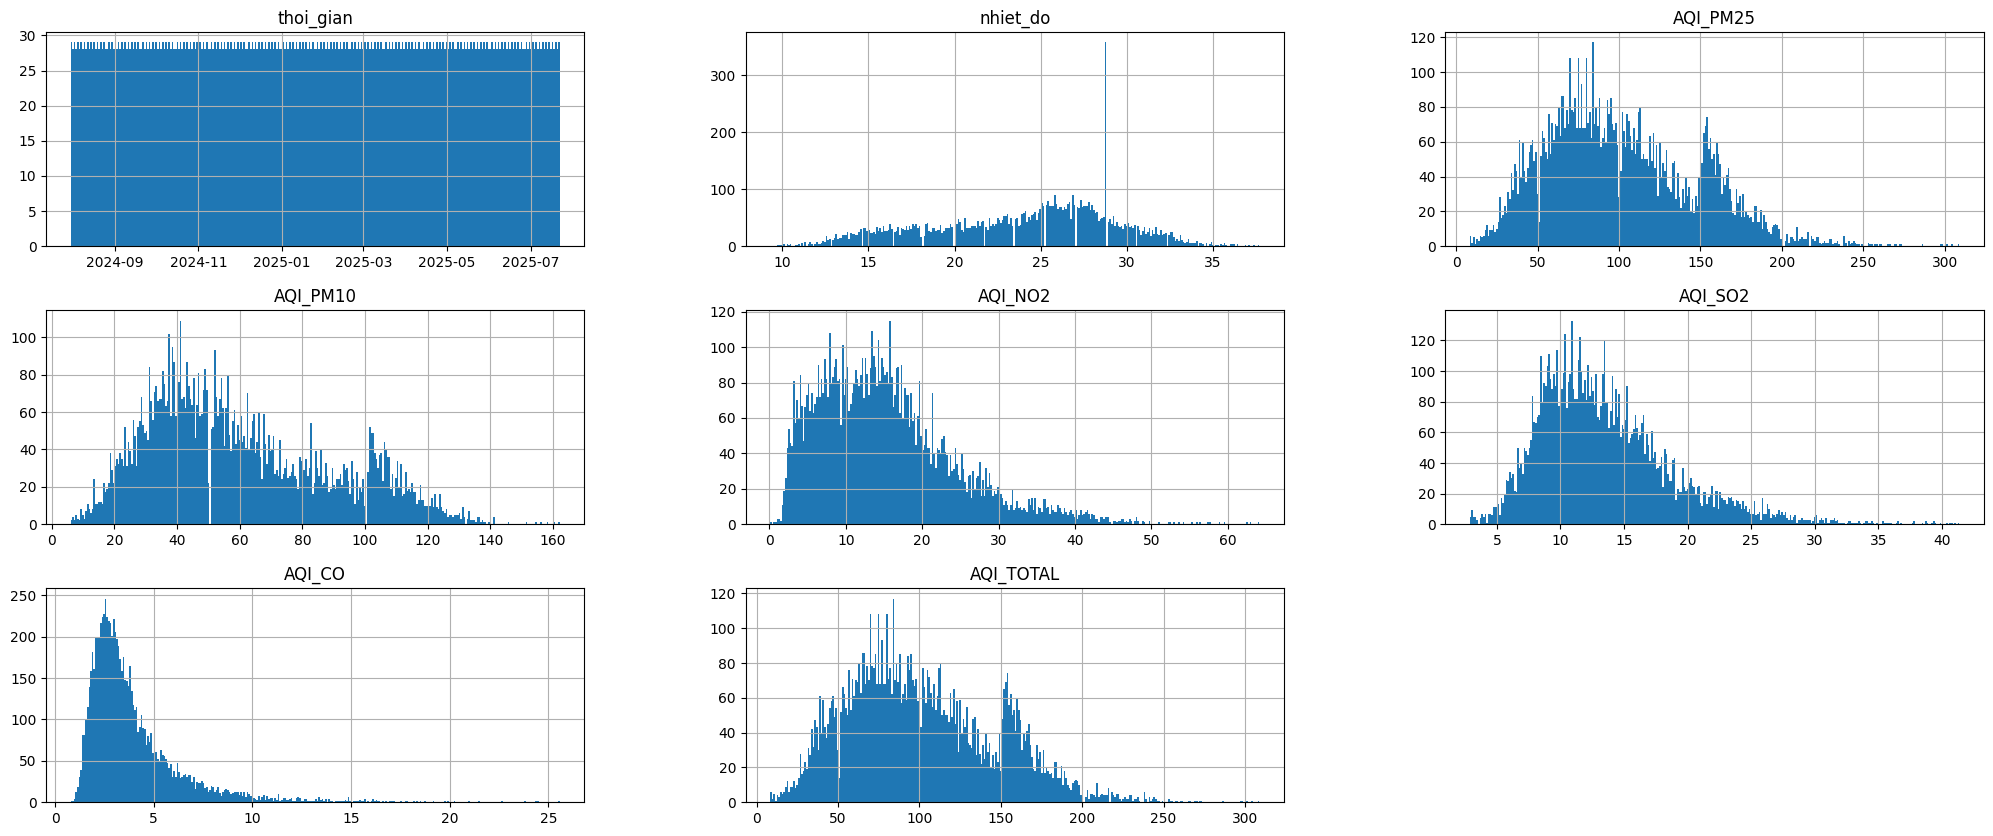

In [ ]:
df.hist(bins=300)
plt.gcf().set_size_inches(25,10)
plt.show()

# Mục mới

Text(0.5, 1.0, 'Autocorrelation plot')

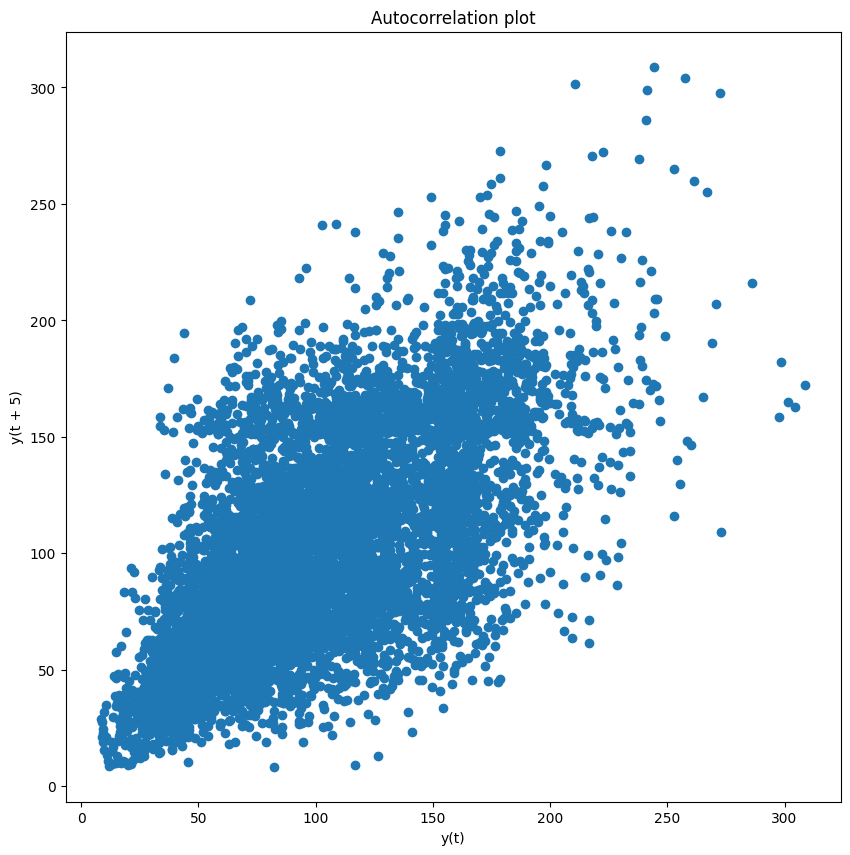

In [ ]:
plt.figure(figsize=(10,10))
lag_plot(df["AQI_TOTAL"], lag=5)
plt.title('Autocorrelation plot')

In [ ]:
df.isnull().sum()

,0
thoi_gian,0
location_name,0
nhiet_do,0
AQI_PM25,0
AQI_PM10,0
AQI_NO2,0
AQI_SO2,0
AQI_CO,0
AQI_TOTAL,0


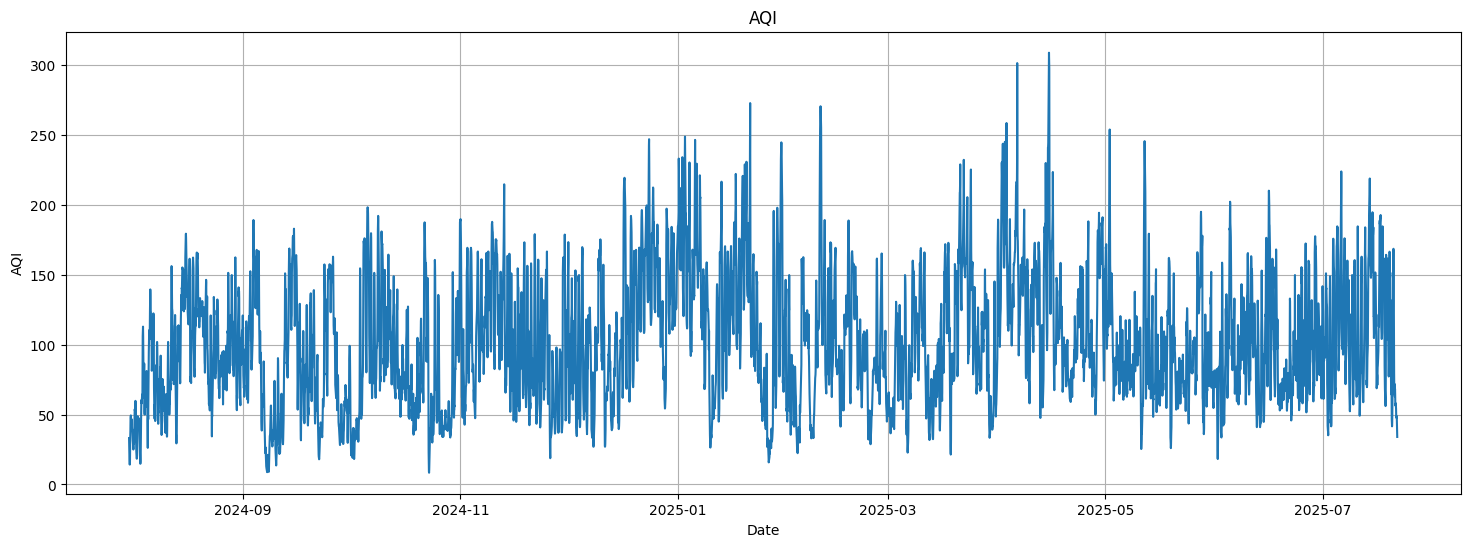

In [ ]:
#plot close price
plt.figure(figsize=(18,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('AQI từ ')
plt.plot(df["thoi_gian"],df['AQI_TOTAL'])
plt.title('AQI')
plt.show()

Mô hình ARIMA

In [14]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
result = adfuller(df['AQI_TOTAL'].dropna())
print("- | ADF Statistic:", result[0])
print("- | p-value:", result[1])
if result[1] <= 0.05:
  print("- | Chuỗi là dừng (stationary) → có thể dùng ARIMA trực tiếp với d = 0")
else:
  print("- | Chuỗi KHÔNG dừng → cần differencing (d ≥ 1)")


- | ADF Statistic: -9.492191413524482
- | p-value: 3.6276498677472675e-16
- | Chuỗi là dừng (stationary) → có thể dùng ARIMA trực tiếp với d = 0


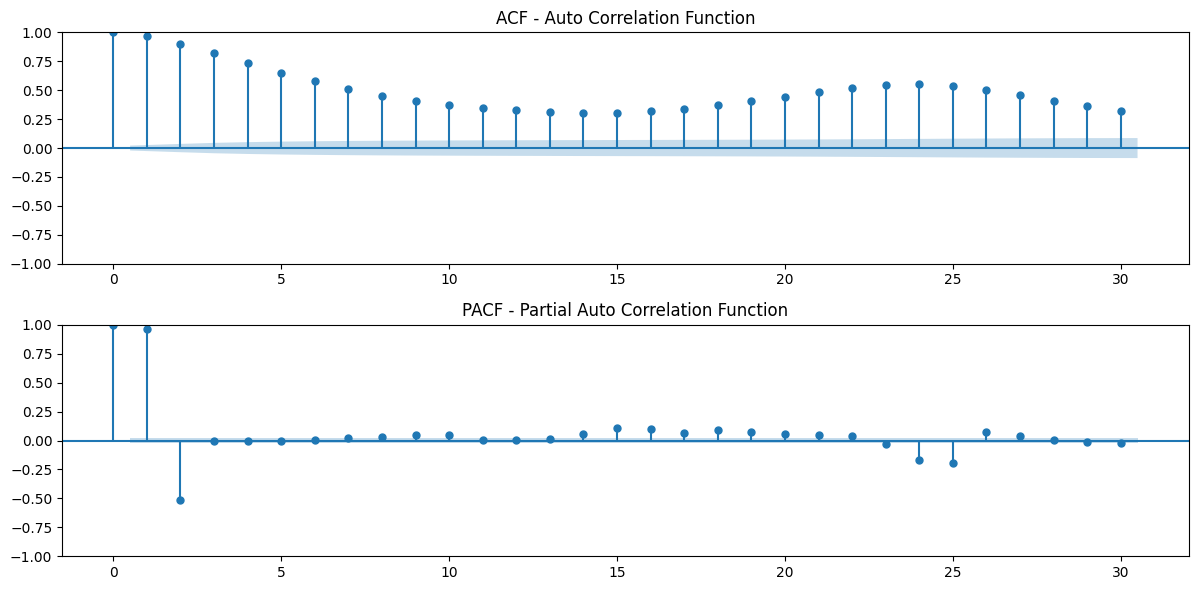

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2,1, figsize=(12,6))
plot_acf(df['AQI_TOTAL'].dropna(), ax=ax[0], lags=30)
ax[0].set_title("ACF - Auto Correlation Function")
plot_pacf(df['AQI_TOTAL'].dropna(), ax=ax[1], lags=30)
ax[1].set_title("PACF - Partial Auto Correlation Function")
plt.tight_layout()
plt.show()

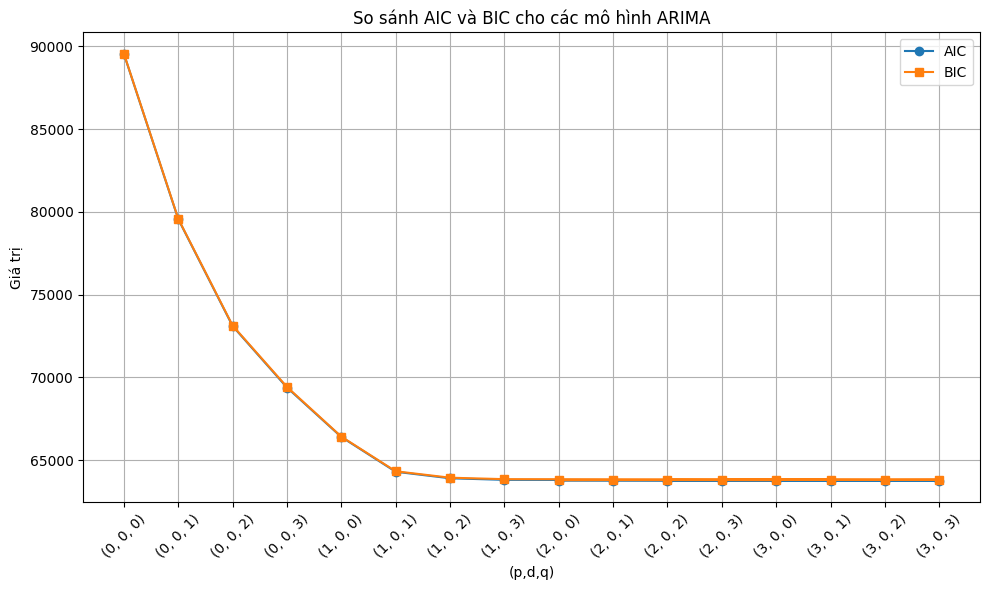


📊 Top 5 mô hình có AIC thấp nhất:
        order           AIC           BIC
8   (2, 0, 0)  63762.634092  63790.846031
9   (2, 0, 1)  63764.561001  63799.825924
12  (3, 0, 0)  63764.561427  63799.826350
10  (2, 0, 2)  63766.053419  63808.371327
13  (3, 0, 1)  63766.393064  63808.710971


In [20]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

def test_pdq(data, orders):
    results = []
    for order in orders:
        try:
            model = ARIMA(data, order=order)
            model_fit = model.fit()
            results.append({
                "order": order,
                "AIC": model_fit.aic,
                "BIC": model_fit.bic
            })
        except Exception as e:
            results.append({
                "order": order,
                "AIC": None,
                "BIC": None
            })
            print(f"{order} lỗi: {e}")
    
    # Chuyển sang DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.dropna().sort_values(by="AIC")
    
    # Vẽ biểu đồ AIC và BIC
    plt.figure(figsize=(10, 6))
    plt.plot(results_df.index, results_df["AIC"], marker="o", label="AIC")
    plt.plot(results_df.index, results_df["BIC"], marker="s", label="BIC")
    plt.xticks(results_df.index, results_df["order"], rotation=45)
    plt.xlabel("(p,d,q)")
    plt.ylabel("Giá trị")
    plt.title("So sánh AIC và BIC cho các mô hình ARIMA")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return results_df

# Tạo list mở rộng: p = 0..3, d = 0, q = 0..3
param_list = [(p, 0, q) for p in range(0, 4) for q in range(0, 4)]

# Vì đã kiểm định dừng → d = 0
results_df = test_pdq(df['AQI_TOTAL'], param_list)

print("\n📊 Top 5 mô hình có AIC thấp nhất:")
print(results_df.head())


In [ ]:


def adf_test(series, maxlag=30, max_points=5000, max_diff=2):
    series = series.dropna()
    if len(series) < 10:
        print("❌ Chuỗi quá ngắn để kiểm định ADF.")
        return None

    def _subsample(s):
        n = len(s)
        if n > max_points:
            idx = np.linspace(0, n - 1, max_points, dtype=int)
            print(f"⚠️ Chuỗi dài {n}, dùng mẫu {max_points} điểm.")
            return s.iloc[idx]
        return s

    for d in range(0, max_diff + 1):
        if d > 0:
            series = series.diff().dropna()
            print(f"\n--- Kiểm định sau {d} lần lấy sai phân ---")
        else:
            print(f"\n--- Kiểm định d = {d} ---")

        s = _subsample(series)
        try:
            stat, pval, _, _, crit_vals, _ = adfuller(s, maxlag=maxlag, autolag='BIC')
            print(f"ADF Statistic: {stat:.4f}")
            print(f"p-value: {pval:.4f}")
            for k, v in crit_vals.items():
                print(f"Critical Value ({k}): {v:.4f}")
            if pval <= 0.05:
                print("✅ Dữ liệu có tính dừng")
                return {"adf_stat": stat, "p_value": pval, "diffs": d}
            else:
                print("❌ Dữ liệu không có tính dừng")
        except Exception as e:
            print(f"Lỗi khi kiểm định ADF: {e}")
            return None

    print(f"Không đạt tính dừng sau tối đa {max_diff} lần lấy sai phân.")
    return {"adf_stat": stat, "p_value": pval, "diffs": max_diff}


In [ ]:
adf_test(df['AQI_TOTAL'].dropna())


--- Kiểm định d = 0 ---
⚠️ Chuỗi dài 8544, dùng mẫu 5000 điểm.
ADF Statistic: -9.1295
p-value: 0.0000
Critical Value (1%): -3.4317
Critical Value (5%): -2.8621
Critical Value (10%): -2.5671
✅ Dữ liệu có tính dừng


{'adf_stat': np.float64(-9.129534103802541),
 'p_value': np.float64(3.048496458284859e-15),
 'diffs': 0}

xt = xt - xt-1

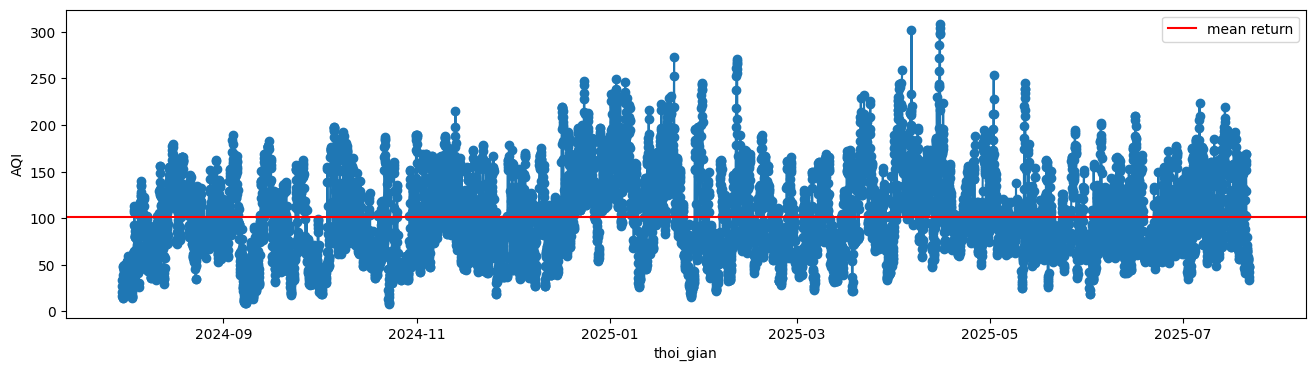

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(df["thoi_gian"], df['AQI_TOTAL'], '-o')
plt.axhline(y=np.nanmean(df['AQI_TOTAL']), label='mean return', c='red')

plt.xlabel('thoi_gian')
plt.ylabel('AQI')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Lấy mẫu đều nếu quá lớn
def subsample_series(s, max_points=5000):
    s = s.dropna()
    n = len(s)
    if n > max_points:
        idx = np.linspace(0, n - 1, max_points, dtype=int)
        return s.iloc[idx]
    return s

series = subsample_series(df['AQI_TOTAL'])


<Figure size 600x400 with 0 Axes>

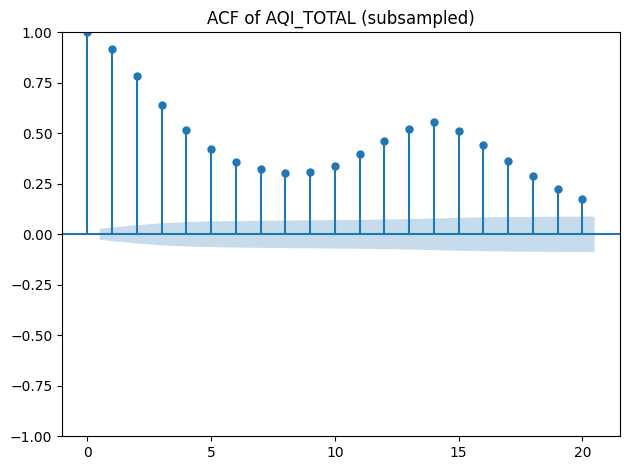

In [ ]:
plt.figure(figsize=(6,4))
plot_acf(series, lags=20, alpha=0.05, zero=True, use_vlines=True)
plt.title("ACF of AQI_TOTAL (subsampled)")
plt.tight_layout()

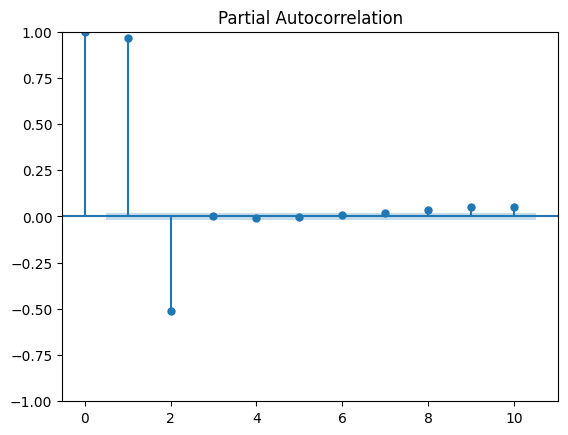

<Figure size 800x600 with 0 Axes>

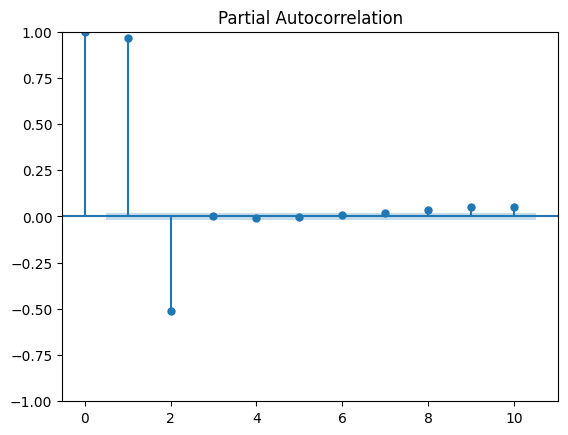

In [ ]:
plt.figure(figsize = (8, 6))
plot_pacf(df['AQI_TOTAL'].dropna(), lags=10)

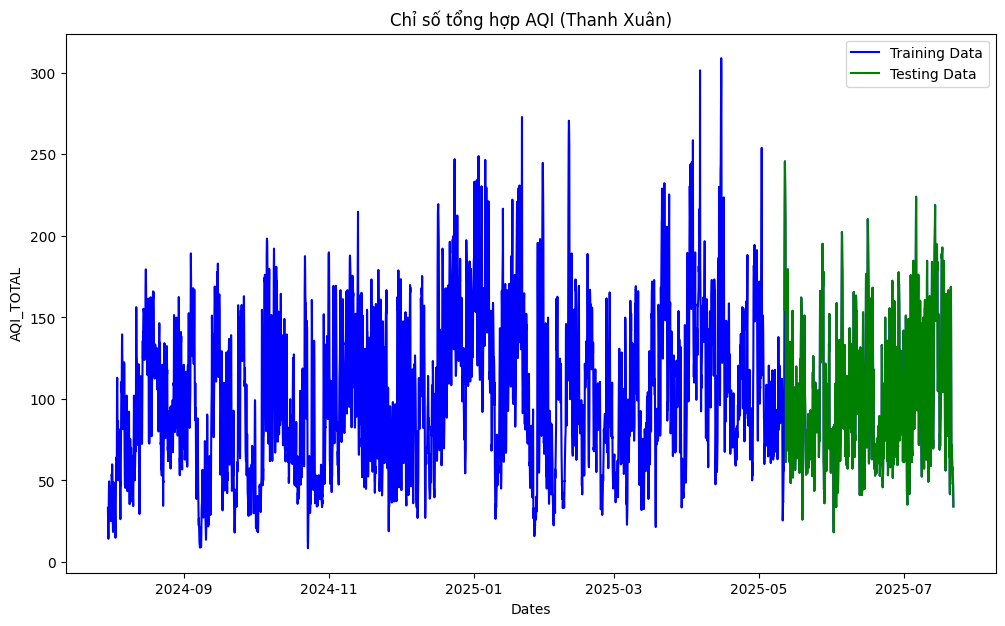

In [11]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(12,7))
plt.title('Chỉ số tổng hợp AQI (Thanh Xuân)')
plt.xlabel('Dates')
plt.ylabel('AQI_TOTAL')
plt.plot(df["thoi_gian"],df["AQI_TOTAL"], 'blue', label='Training Data')
plt.plot(test_data["thoi_gian"],test_data["AQI_TOTAL"], 'green', label='Testing Data')
plt.legend()

Xu hướng tăng dài hạn: Từ 2020 đến đầu 2024, giá cổ phiếu FPT có xu hướng tăng đều, từ khoảng 25 → hơn 100.

Giai đoạn bứt phá: Đầu năm 2024, cổ phiếu tăng mạnh, vượt 140, cho thấy giai đoạn tăng trưởng nhanh hoặc được thị trường kỳ vọng lớn.

Giai đoạn điều chỉnh (cuối 2024–2025): Giá cổ phiếu giảm mạnh trong giai đoạn dữ liệu kiểm tra. Đây có thể là:

Phản ứng với tin tức xấu hoặc hiệu suất tài chính giảm.


Điều chỉnh kỹ thuật sau giai đoạn tăng nóng.

In [ ]:
def _arima_fit(orders, data):
  models = dict()
  for order in orders:
    model = ARIMA(data, order = order).fit()
    model_name = 'ARIMA({},{},{})'.format(order[0], order[1], order[2])
    print('{} --> AIC={}; BIC={}'.format(model_name, model.aic, model.bic))
    models[model_name] = model
  return models

orders = [(1, 1, 0), (2, 1, 0), (3, 1, 0), (4, 1, 0), (5,1,0)]
models = _arima_fit(orders, train_data["AQI_TOTAL"].values)

ARIMA(1,1,0) --> AIC=50589.35368832019; BIC=50603.01301918554
ARIMA(2,1,0) --> AIC=50549.327270248774; BIC=50569.8162665468
ARIMA(3,1,0) --> AIC=50541.22802036055; BIC=50568.54668209125
ARIMA(4,1,0) --> AIC=50534.67531326558; BIC=50568.82364042896
ARIMA(5,1,0) --> AIC=50515.54943421646; BIC=50556.527426812514


1.  AIC (Akaike Information Criterion):
Là thước đo độ phù hợp của mô hình với dữ liệu.

Càng thấp càng tốt → mô hình phù hợp hơn, nhưng không quá phức tạp.

AIC penalizes (phạt) mô hình có quá nhiều tham số để tránh overfitting.

2. BIC (Bayesian Information Criterion):
Cũng là thước đo độ phù hợp của mô hình, nhưng phạt mạnh hơn AIC nếu mô hình quá phức tạp.

Càng thấp càng tốt.


Mô hình ARIMA(5,1,0) là lựa chọn tốt vì có BIC thấp nhất, và AIC vẫn trong mức chấp nhận. Đây là mô hình cân bằng tốt giữa độ chính xác và độ đơn giản.



In [12]:
train_ar = train_data["AQI_TOTAL"].values
test_ar = test_data["AQI_TOTAL"].values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range (len(test_ar)):
    model = ARIMA(history, order=(1, 0, 2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)


<class 'list'>


C:\Users\Cong\AppData\Local\Temp\ipykernel_23524\2192502709.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "green" (-> color=(0.0, 0.5019607843137255, 0.0, 1.0)). The keyword argument will take precedence.
  plt.plot(df["thoi_gian"],df["AQI_TOTAL"],'green', color='blue', label='Training Data')


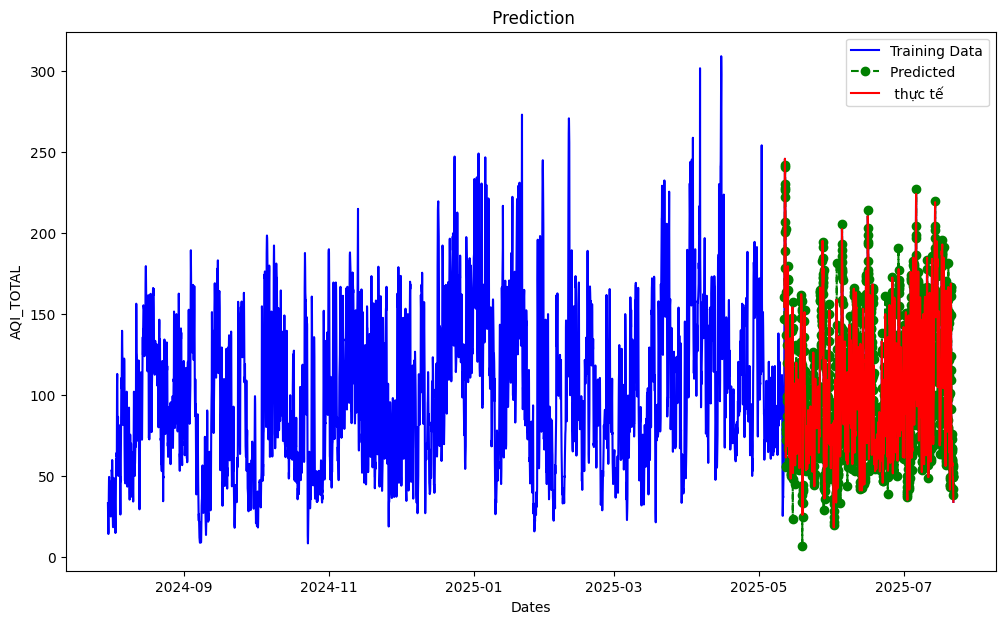

In [14]:
plt.figure(figsize=(12,7))
plt.plot(df["thoi_gian"],df["AQI_TOTAL"],'green', color='blue', label='Training Data')
plt.plot(test_data["thoi_gian"], predictions, color='green', marker='o', linestyle='dashed',
         label='Predicted ')
plt.plot(test_data["thoi_gian"], test_data["AQI_TOTAL"], color='red', label=' thực tế')
plt.title(' Prediction')
plt.xlabel('Dates')
plt.ylabel('AQI_TOTAL')
plt.legend()

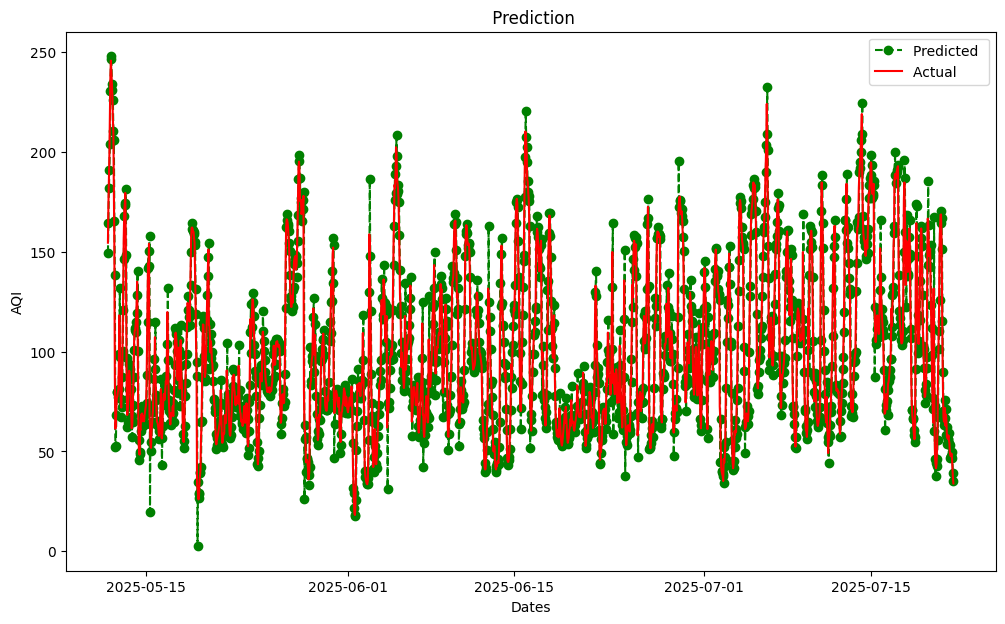

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(test_data["thoi_gian"], predictions, color='green', marker='o', linestyle='dashed',
         label='Predicted ')
plt.plot(test_data["thoi_gian"], test_data["AQI_TOTAL"], color='red', label='Actual ')
plt.title(' Prediction')
plt.xlabel('Dates')
plt.ylabel('AQI')
plt.legend()

In [ ]:
actual=pd.DataFrame()
actual=pd.DataFrame(test_ar,columns=["Actual"])
predicted=pd.DataFrame(list(predictions),columns=["Predicted"])
actual=actual.reset_index(drop=True)
predicted=predicted.reset_index(drop=True)
output=pd.concat([actual,predicted],axis=1)
print(output)

       Actual   Predicted
0     154.500  149.337581
1     173.890  164.531397
2     186.630  181.741385
3     198.950  190.874248
4     220.305  203.877111
...       ...         ...
1704   49.000   47.591775
1705   47.600   49.968992
1706   42.000   46.895734
1707   37.400   39.172506
1708   34.000   35.196535

[1709 rows x 2 columns]


In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_metrics(y_true, y_pred):
    # MSE
    mse = mean_squared_error(y_true, y_pred)
    # RMSE
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    # MAPE (dạng %)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    # R2 Score
    r2 = r2_score(y_true, y_pred)
    
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.4f}")
    
    return mse, rmse, mae, mape, r2


In [13]:
mse, rmse, mae, mape, r2 = evaluate_metrics(test_data["AQI_TOTAL"], predictions)


MSE  : 146.9742
RMSE : 12.1233
MAE  : 7.5104
MAPE : 8.18%
R²   : 0.9062


LSTM

In [15]:
df = df[['AQI_TOTAL', "thoi_gian"]]
source = df[['AQI_TOTAL']].values
trainSize = int(source.size * 80 / 100)
trainData = source[:trainSize]
sc = MinMaxScaler(feature_range=(0, 1))
# preprocess data
scTrain = sc.fit_transform(trainData)

blockSize = 24
xTrain = []
yTrain = []
# tạo ra 1 mảng chứa những mảng có blockSize phần tử
for i in range(blockSize, trainSize):
  xTrain.append(scTrain[i - blockSize:i, 0])
  yTrain.append(scTrain[i, 0])

# return numpy array
xTrain = np.array(xTrain)

xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))

yTrain = np.array(yTrain)
yTrain = np.reshape(yTrain, (yTrain.shape[0], 1))


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Create model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(xTrain.shape[1], xTrain.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Dùng MAE - sai số tuyệt đối trung bình
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()


C:\Users\Cong\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,251 (356.45 KB)

 Trainable params: 91,251 (356.45 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

savedModel = "model.keras"   # GIỮ NGUYÊN tên & đuôi .keras

# Callback lưu mô hình tốt nhất (chỉ khi val_loss cải thiện ⇒ bớt I/O)
ckpt = ModelCheckpoint(
    filepath=savedModel,
    monitor="val_loss",       # theo dõi trên validation
    save_best_only=True,
    verbose=1
)

# Callback dừng sớm nếu 10 epoch liên tiếp không cải thiện
early = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model.fit(
    xTrain,
    yTrain,
    epochs=120,               # vẫn 120 nhưng sẽ dừng sớm
    batch_size=32,            # lớn hơn 5 để giảm số bước/epoch
    validation_split=0.1,     # cần cho val_loss
    verbose=2,
    callbacks=[ckpt, early]
)



Epoch 1/120

Epoch 1: val_loss improved from inf to 0.09130, saving model to model.keras
192/192 - 19s - 101ms/step - loss: 0.1146 - val_loss: 0.0913
Epoch 2/120

Epoch 2: val_loss improved from 0.09130 to 0.07672, saving model to model.keras
192/192 - 13s - 67ms/step - loss: 0.0978 - val_loss: 0.0767
Epoch 3/120

Epoch 3: val_loss improved from 0.07672 to 0.06203, saving model to model.keras
192/192 - 12s - 61ms/step - loss: 0.0779 - val_loss: 0.0620
Epoch 4/120

Epoch 4: val_loss improved from 0.06203 to 0.04309, saving model to model.keras
192/192 - 18s - 93ms/step - loss: 0.0601 - val_loss: 0.0431
Epoch 5/120

Epoch 5: val_loss improved from 0.04309 to 0.03345, saving model to model.keras
192/192 - 12s - 64ms/step - loss: 0.0486 - val_loss: 0.0334
Epoch 6/120

Epoch 6: val_loss improved from 0.03345 to 0.03031, saving model to model.keras
192/192 - 17s - 91ms/step - loss: 0.0403 - val_loss: 0.0303
Epoch 7/120

Epoch 7: val_loss improved from 0.03031 to 0.02453, saving model to mode

In [18]:
#Use model

# revert yTrain form 0 ~ 1 to real value

yTrainInverse = sc.inverse_transform(yTrain)

modelLoaded = load_model(savedModel)
yTrainPredict = modelLoaded.predict(xTrain)
yTrainPredict = sc.inverse_transform(yTrainPredict)



213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


In [19]:
# Tạo tập valid có kèm blockSize quá khứ để tạo window
validData = source[trainSize - blockSize:]  # shape (M,1)

# DÙNG scaler đã fit trên train
scValid = sc.transform(validData)

# Tạo xValid
xValid = []
for i in range(blockSize, scValid.shape[0]):
    xValid.append(scValid[i - blockSize:i, 0])

xValid = np.array(xValid).reshape(-1, blockSize, 1)

# Dự đoán & inverse bằng scaler của train
modelLoaded = load_model(savedModel)
yValidPredict = modelLoaded.predict(xValid)
yValidPredict = sc.inverse_transform(yValidPredict)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [ ]:
df

,AQI_TOTAL,thoi_gian
0,33.2,2024-07-31 00:00:00+00:00
2,26.8,2024-07-31 01:00:00+00:00
4,21.0,2024-07-31 02:00:00+00:00
6,16.6,2024-07-31 03:00:00+00:00
8,14.4,2024-07-31 04:00:00+00:00
...,...,...
12259,49.0,2025-07-21 19:00:00+00:00
12260,47.6,2025-07-21 20:00:00+00:00
12261,42.0,2025-07-21 21:00:00+00:00
12262,37.4,2025-07-21 22:00:00+00:00


C:\Users\Cong\AppData\Local\Temp\ipykernel_23524\2482650811.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTrain.loc[:, "predict"] = yTrainPredict
C:\Users\Cong\AppData\Local\Temp\ipykernel_23524\2482650811.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfValid["predict"] = yValidPredict


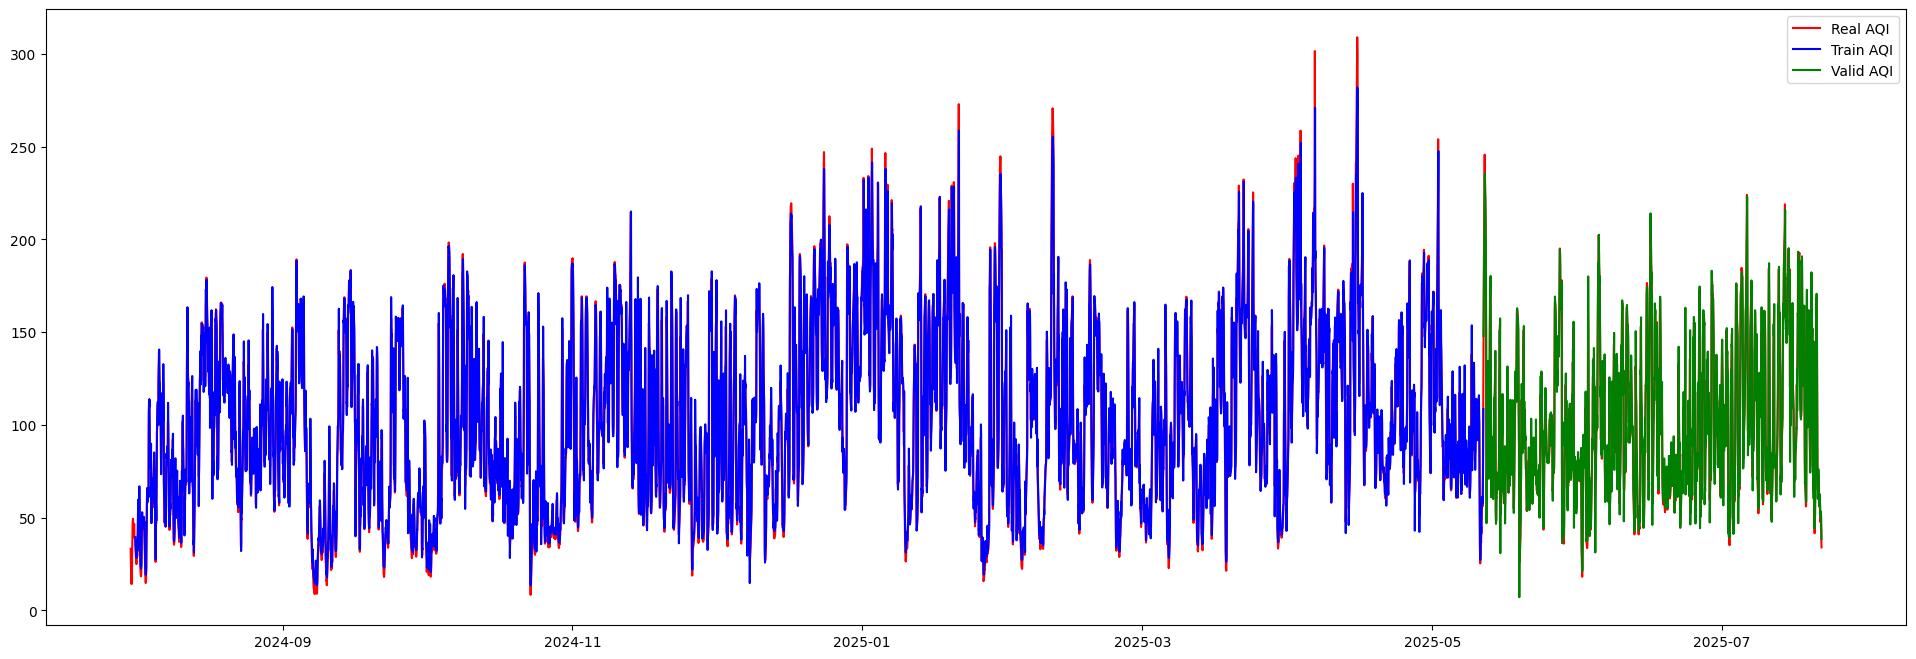

In [20]:
# Biểu đồ so sánh
dfTrain = df[blockSize:trainSize]
dfValid = df[trainSize:]

plt.figure(figsize=(24, 8))
plt.plot(df["thoi_gian"], df["AQI_TOTAL"], label="Real AQI", color="red")

dfTrain.loc[:, "predict"] = yTrainPredict
plt.plot(dfTrain["thoi_gian"], dfTrain["predict"] ,label="Train AQI", color="blue")

dfValid["predict"] = yValidPredict
plt.plot(dfValid["thoi_gian"], dfValid["predict"] ,label="Valid AQI", color="green")

plt.legend()

In [ ]:
df[trainSize:]

,AQI_TOTAL,thoi_gian
10555,154.500,2025-05-11 19:00:00+00:00
10556,173.890,2025-05-11 20:00:00+00:00
10557,186.630,2025-05-11 21:00:00+00:00
10558,198.950,2025-05-11 22:00:00+00:00
10559,220.305,2025-05-11 23:00:00+00:00
...,...,...
12259,49.000,2025-07-21 19:00:00+00:00
12260,47.600,2025-07-21 20:00:00+00:00
12261,42.000,2025-07-21 21:00:00+00:00
12262,37.400,2025-07-21 22:00:00+00:00


In [ ]:
# print("Độ phù hợp của tập train", r2_score(trainData, yTrainPredict))
# print("Sai số tuyệt đối trung bình", mean_absolute_error(trainData, yTrainPredict))
# print("Phần trăm sai số tuyệt đối trung bình", mean_absolute_percentage_error(trainData, yTrainPredict))

In [24]:
y_valid = source[trainSize:]
mse, rmse, mae, mape, r2 = evaluate_metrics(y_valid, yValidPredict)


MSE  : 140.0766
RMSE : 11.8354
MAE  : 7.2811
MAPE : 8.00%
R²   : 0.9106


In [22]:
# Kiểm tra tập valid với dự đoán của tập valid

yValid = source[trainSize:]
print("Độ phù hợp", r2_score(yValid, yValidPredict))
print("Sai số tuyệt đối trung bình", mean_absolute_error(yValid, yValidPredict))
print("Phần trăm sai số tuyệt đối trung bình", mean_absolute_percentage_error(yValid, yValidPredict))

Độ phù hợp 0.9105728939900075
Sai số tuyệt đối trung bình 7.281051451945505
Phần trăm sai số tuyệt đối trung bình 0.08004157206515303


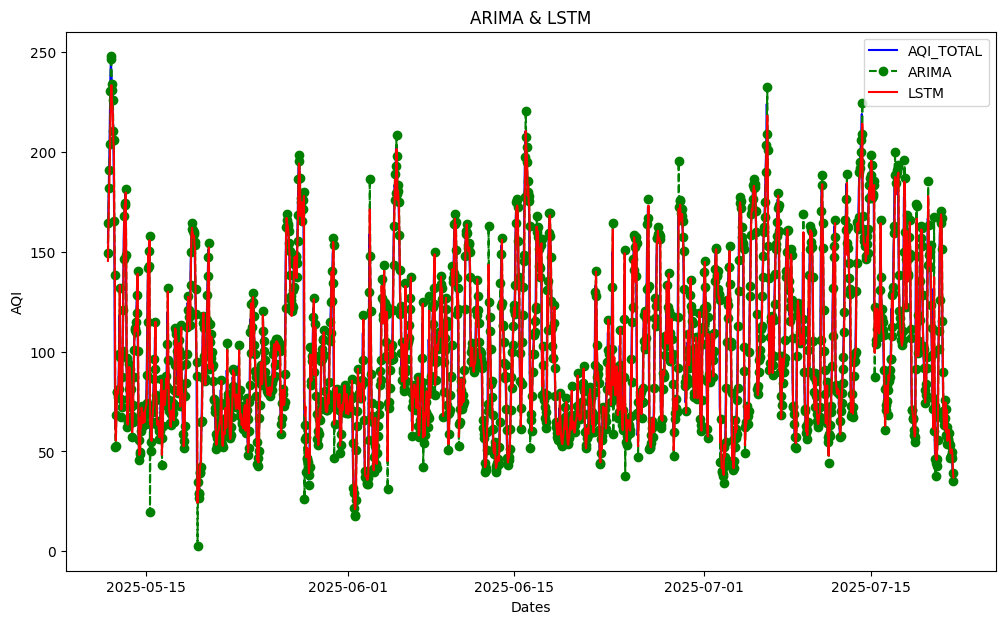

In [ ]:
  plt.figure(figsize=(12,7))

  plt.plot(test_data["thoi_gian"], test_data["AQI_TOTAL"], color='blue', label='AQI_TOTAL')
  plt.plot(test_data["thoi_gian"], predictions, color='green', marker='o', linestyle='dashed',
          label='ARIMA')
  plt.plot(test_data["thoi_gian"], dfValid["predict"], color='red', label='LSTM')
  plt.title('ARIMA & LSTM')
  plt.xlabel('Dates')
  plt.ylabel('AQI')
  plt.legend()

Dự báo 7 ngày tới (theo giờ):
                           AQI_TOTAL
2025-07-22 00:00:00+00:00  34.000000
2025-07-22 01:00:00+00:00  41.004243
2025-07-22 02:00:00+00:00  43.765343
2025-07-22 03:00:00+00:00  49.607171
2025-07-22 04:00:00+00:00  56.463989 ...
                            AQI_TOTAL
2025-07-28 19:00:00+00:00  46.920207
2025-07-28 20:00:00+00:00  45.833553
2025-07-28 21:00:00+00:00  41.400339
2025-07-28 22:00:00+00:00  37.737925
2025-07-28 23:00:00+00:00  35.013493


/tmp/ipython-input-733275086.py:121: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(start=last_ts + pd.Timedelta(hours=1),


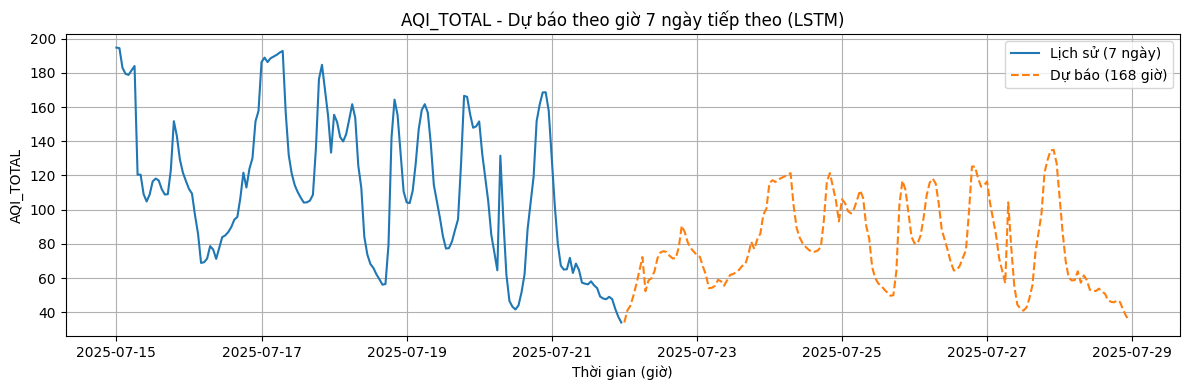

In [ ]:
# --- Tuỳ chọn điều khiển ---
HOURS_FORWARD = 24 * 7      # đổi thành 24 nếu chỉ muốn 1 ngày
ANCHOR_MODE   = "week"      # "week" (168h), "day" (24h), hoặc None để tắt neo
GAMMA_START, GAMMA_END = 0.6, 0.2  # trọng số tin vào ML (gần -> xa)
CLIP_MODE     = "quantile"  # "quantile" (khuyên dùng) hoặc "range"

value_col = "AQI_TOTAL"
time_col  = "thoi_gian"

# 0) Chuẩn hoá index thời gian (không đụng dữ liệu train ở trên)
# _df = df.copy()
# if time_col in _df.columns:
#     _df[time_col] = pd.to_datetime(_df[time_col])
#     _df = _df.sort_values(time_col).set_index(time_col)
# else:
#     if not isinstance(_df.index, pd.DatetimeIndex):
#         _df.index = pd.to_datetime(_df.index)
#     _df = _df.sort_index()

# _df[value_col] = pd.to_numeric(_df[value_col], errors="coerce")
# _df = _df.dropna(subset=[value_col])

# 1) Lấy source và blockSize đã dùng để train
source = _df[value_col].astype("float32").to_numpy().reshape(-1, 1)
try:
    blockSize
except NameError:
    blockSize = 168
if len(source) < blockSize + 1:
    raise ValueError(f"Cần ≥ {blockSize+1} điểm dữ liệu, hiện có {len(source)}.")

# 2) Dùng lại scaler đã fit; nếu chưa có thì fit theo trainData
from sklearn.preprocessing import MinMaxScaler
try:
    sc_train
except NameError:
    # nếu chưa có sc_train, fit lại từ trainData (đúng như trên)
    try:
        trainData
    except NameError:
        train_len = max(int(len(source) * 0.8), blockSize + 1)
        trainData = source[:train_len]
    sc_train = MinMaxScaler(feature_range=(0, 1))
    sc_train.fit(trainData)

scaled_full = sc_train.transform(source).astype("float32")

# Biên clip trong không gian scaled & miền gốc
min_s = sc_train.transform([[sc_train.data_min_[0]]])[0, 0]
max_s = sc_train.transform([[sc_train.data_max_[0]]])[0, 0]
ymin, ymax = float(sc_train.data_min_[0]), float(sc_train.data_max_[0])

# 2.1) Nếu dùng CLIP theo phân vị (ổn định hơn range tuyệt đối)
if CLIP_MODE == "quantile":
    # phân vị tính trên TRAIN (đã về đơn vị gốc)
    q_low, q_high = np.quantile(trainData.reshape(-1), [0.01, 0.99])
    q_low = max(0.0, float(q_low))  # AQI ≥ 0
else:
    q_low, q_high = max(0.0, ymin), ymax

# 3) Bias correction nhanh bằng backtest 1-step trên đuôi chuỗi
back_h = min(168, len(scaled_full) - blockSize)
bias = 0.0
if back_h > 0:
    preds_bt, trues_bt = [], []
    for i in range(len(scaled_full) - back_h, len(scaled_full)):
        win = scaled_full[i - blockSize:i].reshape(1, blockSize, 1)
        p = float(np.ravel(modelLoaded.predict(win, verbose=0))[0])
        preds_bt.append(np.clip(p, min_s, max_s))
        trues_bt.append(scaled_full[i, 0])
    preds_bt = sc_train.inverse_transform(np.array(preds_bt, dtype="float32").reshape(-1, 1)).ravel()
    trues_bt = sc_train.inverse_transform(np.array(trues_bt, dtype="float32").reshape(-1, 1)).ravel()
    # median bền vững hơn mean
    bias = float(np.median(preds_bt - trues_bt))

# 4) Dự báo lặp theo giờ bằng chính modelLoaded
last_window = scaled_full[-blockSize:].reshape(1, blockSize, 1)
forecasts_scaled = []
for _ in range(HOURS_FORWARD):
    pred = modelLoaded.predict(last_window, verbose=0)   # kỳ vọng (1,1) hoặc (1,)
    next_scaled = float(np.ravel(pred)[0])
    next_scaled = np.clip(next_scaled, min_s, max_s)     # kẹp trong miền scaled
    forecasts_scaled.append(next_scaled)
    win_flat = np.append(last_window.reshape(-1), next_scaled)[-blockSize:]
    last_window = win_flat.reshape(1, blockSize, 1)

# 5) Nghịch chuẩn + hiệu chỉnh bias
forecasts = sc_train.inverse_transform(
    np.array(forecasts_scaled, dtype="float32").reshape(-1, 1)
).ravel()
if bias != 0.0:
    forecasts = forecasts - bias

# 6) Neo mùa vụ (tuỳ chọn) để triệt drift xa chân trời
if ANCHOR_MODE in ("week", "day"):
    base_len = 168 if ANCHOR_MODE == "week" else 24
    baseline = sc_train.inverse_transform(scaled_full[-base_len:]).ravel()
    gammas = np.linspace(GAMMA_START, GAMMA_END, HOURS_FORWARD)
    # nếu dự báo dài hơn baseline (tuần/ngày), lặp baseline theo chu kỳ
    if HOURS_FORWARD > base_len:
        reps = int(np.ceil(HOURS_FORWARD / base_len))
        baseline = np.tile(baseline, reps)[:HOURS_FORWARD]
    forecasts = baseline + gammas * (forecasts - baseline)

# 7) Kẹp miền gốc (ưu tiên phân vị để tránh outlier)
forecasts = np.clip(forecasts, q_low, q_high)
# 8) Lấy 7 ngày cuối THEO THỜI GIAN (giữ nguyên điểm gốc, KHÔNG resample)
end_ts = _df.index.max()
start_ts = end_ts - pd.Timedelta(hours=168)
hist = _df.loc[_df.index > start_ts].copy()
last_ts = hist.index[-1]

# (tuỳ chọn) Bridge vài giờ đầu để tránh "nhảy bậc" tại điểm nối lịch sử ↔ dự báo
BRIDGE_H = min(12, HOURS_FORWARD)  # đặt =0 nếu muốn giữ nguyên dự báo
if BRIDGE_H > 0:
    last_actual = float(hist[value_col].iloc[-1])
    offset = last_actual - float(forecasts[0])
    forecasts[:BRIDGE_H] = forecasts[:BRIDGE_H] + offset * np.linspace(1.0, 0.0, BRIDGE_H)

# Future index: theo giờ, bắt đầu ngay sau mốc cuối của 'hist'
future_index = pd.date_range(start=last_ts + pd.Timedelta(hours=1),
                             periods=HOURS_FORWARD, freq="H")

forecast_df = pd.DataFrame({value_col: forecasts}, index=future_index)

print("Dự báo 7 ngày tới (theo giờ):")
print(forecast_df.head(), "...\n", forecast_df.tail())

# 9) Vẽ: dùng đúng 'hist' + forecast để liền mạch
plt.figure(figsize=(12,4))
plt.plot(hist.index, hist[value_col], label="Lịch sử (7 ngày)")
plt.plot(forecast_df.index, forecast_df[value_col], "--", label=f"Dự báo ({HOURS_FORWARD} giờ)")
plt.title(f"{value_col} - Dự báo theo giờ 7 ngày tiếp theo (LSTM)")
plt.xlabel("Thời gian (giờ)"); plt.ylabel(value_col)
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()